In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import random
import pysam
import glob
import re
#import genomeview
from pybedtools import BedTool
import mappy as mp
from plotting_utils import figure_path
from matplotlib import rcParams
from peak_utils import *
from tblout_parser import read_tbl

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
peak_path = project_path + '/bed_files/merged_bed/MACS2/annotated'
#peak_path = project_path + '/CLAM//BED_files/peaks/annotation'
peak_tsv = peak_path + '/unfragmented.tsv'
print(peak_tsv)
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype)) \
    .sort_values('pileup', ascending=False)
peak_df.head()

/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.tsv


,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
0,chr1,28975111,28975251,unfragmented.fwd_peak_610,571734,10787.14160,57181.43750,57173.46094,11096.0,15,RNU11,snRNA,+,.,Unannotated,0.0,0.0,Sense
1,chr6,95156834,95156909,unfragmented.rvs_peak_22988,284921,5751.86328,28500.15430,28492.17773,6988.0,15,MTPAP,RBP,-,.,Unannotated,0.0,0.0,Sense
3,chr1,17067008,17067186,unfragmented.fwd_peak_362,131500,2876.29810,13157.49512,13150.05957,3013.0,15,RNU1-4,snRNA,+,RP5-1182A14.7,Long RNA,0.0,0.0,Sense
2,chr15,65597013,65597137,unfragmented.fwd_peak_9467,135357,2768.20337,13543.25586,13535.79297,2811.0,15,RNU5B-1,snRNA,+,.,Unannotated,0.0,0.0,Sense
4,chr12,120729554,120729710,unfragmented.rvs_peak_6648,125818,2579.34473,12589.39648,12581.84961,2617.0,15,U4,snRNA,-,.,Unannotated,0.0,0.0,Sense


In [8]:
ce = color_encoder()
colors = simpsons_palette()
#colors.extend(['black','white'])
random.seed(12)
colors = random.sample(colors, k = len(peak_df.sense_gtype.unique()))
ce.fit(peak_df.sense_gtype, colors)
ce.encoder = {'Long RNA': '#370335',
     'RBP': '#91331F',
     'Repeats': '#197EC0',
     'Unannotated': '#46732E',
     'miRNA': '#FD7446',
     'misc RNA': '#FD8CC1',
     'tRF3':'black',
     'tRF5':'black',
     'piRNA': '#D5E4A2',
     'snRNA': '#8A9197',
     'snoRNA': '#FED439'}

In [9]:
peak_df\
    .query('pileup >= %i & sample_count > %i' %(pileup_cutoff, sample_cutoff))\
    .query('sense_gtype == "Long RNA"')\
    .sort_values('pileup', ascending=False)\
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand)))\
    .assign(is_mt = lambda d: d.seq.map(is_mt))

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,is_mt
11,chr9,35657742,35658019,unfragmented.rvs_peak_26760,70248,1631.99597,7031.63623,7024.80420,1712.0,15,RMRP,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,ACGTGGTTCGTGCTGAAGGCCTGTATCCTAGGCTACACACTGAGGA...,not_MT
13,chr14,20811226,20811574,unfragmented.rvs_peak_7598,50532,1162.15820,5059.95947,5053.27588,1190.0,15,RPPH1,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,TCCCATAGGGCGGAGGGAAGCTCATCAGTGGGGCCACGAGCTGAGT...,not_MT
35,chr16,20733598,20733724,unfragmented.rvs_peak_9747,8493,230.36534,855.38922,849.31488,234.0,15,THUMPD1,Long RNA,-,SFPQ,RBP,0.000000e+00,0.000000e+00,Sense,TAGAACTGCTAACTCATGCCACCATGTTTAATAACATGGCTTTCTC...,not_MT
38,chr9,81357659,81357730,unfragmented.rvs_peak_26940,7419,199.01743,748.02057,741.98444,201.0,15,RP11-506C15.1,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AGAGTAAGGTCAGTTAAATAAGCTAACGGGCCCATACCCCGAAAAT...,not_MT
39,chr10,101817586,101817662,unfragmented.rvs_peak_3553,6763,184.94017,682.32855,676.33337,187.0,15,CPN1,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AGTTCACTGTAAAGCTAACCCAGCATTAACCTTTTAAGTTAAAGAC...,not_MT
40,chr7,63571927,63571997,unfragmented.rvs_peak_24209,6598,179.31273,665.84979,659.86536,181.0,15,RP11-3N2.6,Long RNA,-,RP11-165H4.1,Long RNA,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTAAATAAGCTATCTGGCCCATACCCCAAAAATG...,not_MT
42,chr9,5095156,5095228,unfragmented.fwd_peak_28480,6018,167.16692,607.91943,601.86102,169.0,15,JAK2,Long RNA,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAGTAAGTTCAGCTAAATAAGCTATTGGGCCCATTCTCCTGAAAAT...,not_MT
49,chr4,91759632,91760267,unfragmented.rvs_peak_20013,5343,150.45105,540.27783,534.37006,152.0,15,AC019188.1,Long RNA,-,CCSER1,Long RNA,0.000000e+00,0.000000e+00,Sense,CGACAACTCGGTGGTGGCCACTGCGCAGACCAGACTTCGCTCGTAC...,not_MT
54,chr2,140977935,140978004,unfragmented.rvs_peak_14897,4708,133.00670,476.71683,470.85727,134.0,14,AC092156.2,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTATAAGCTATCGGGCCCATACCCCAAAAATGTT...,not_MT
66,chr13,85095787,85095865,unfragmented.fwd_peak_7796,3436,101.39578,349.48053,343.63879,102.0,14,LINC00333,Long RNA,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense,TAATTTTTAAAGGATAAGACTTATCTGTTGGTCTTAGGAACCCAAA...,not_MT


/stor/home/cdw2854/cfNA/plots/peak_utils.py:429: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0, 1e4)


Plotted:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_qc.pdf


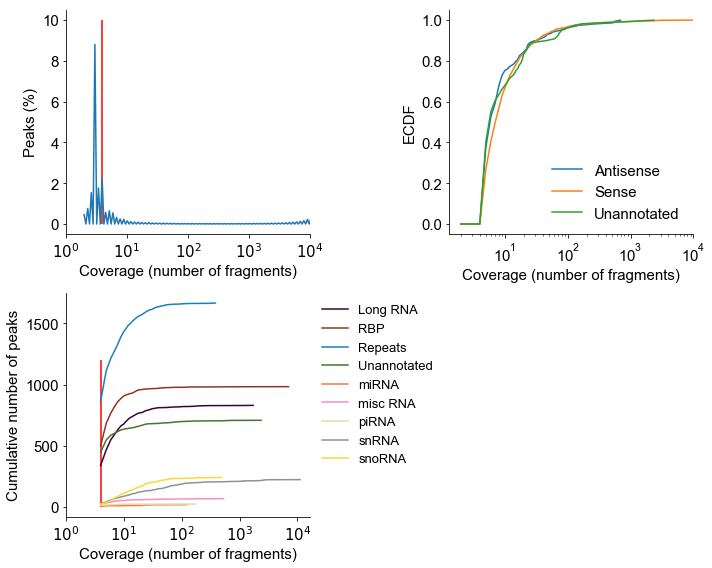

In [10]:
fig = plt.figure(figsize=(10,8))
cov_ax = fig.add_subplot(221)
number_ax = fig.add_subplot(223)
dist_cov_ax = fig.add_subplot(222)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_coverage(peak_df, cov_ax, log=True)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [11]:
peak_df.sense_gtype.unique()

array(['snRNA', 'RBP', 'Unannotated', 'Long RNA', 'misc RNA', 'snoRNA',
       'Repeats', 'piRNA', 'miRNA'], dtype=object)

Saved: /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_figure.pdf


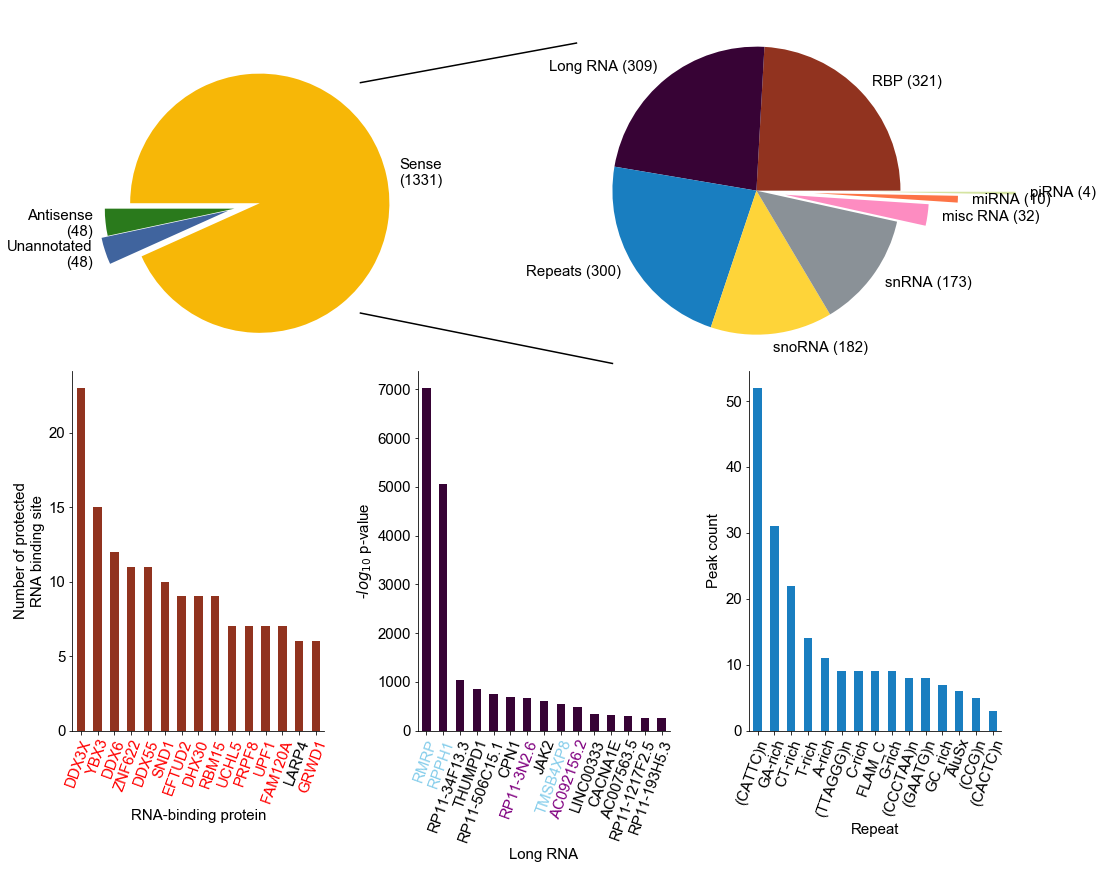

In [12]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.5, 0.45, 0.45])
pie_ax = fig.add_axes([0.6, 0.5, 0.5, 0.5])
rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
plot_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n, y_val = 'log10p')
l1 = mlines.Line2D([0.3,0.6],[0.9,0.955], color= 'black',
                   figure = fig,  transform=fig.transFigure)
l2 = mlines.Line2D([0.3,0.65],[0.58,0.51], color= 'black',
                   figure = fig,  transform=fig.transFigure)
fig.lines.extend([l1, l2])
figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [13]:
import RNA 

lr_peak = peak_df\
    .query('sense_gtype=="Long RNA"') \
    .query('pileup >= %i & sample_count >= %i'%(pileup_cutoff, sample_cutoff))\
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(mt = lambda d: d.seq.map(is_mt))  \
    .assign(shape = lambda d: d.seq.map(RNA.fold))\
    .assign(energy = lambda d: list(map(lambda x: x[1], d['shape'])))\
    .assign(shape = lambda d: list(map(lambda x: x[0], d['shape'])))\
    .assign(width = lambda d: d.end - d.start)\
    .sort_values('log10p', ascending=False)

lr_peak.head(15)

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width
11,chr9,35657742,35658019,unfragmented.rvs_peak_26760,70248,1631.99597,7031.63623,7024.80420,1712.0,15,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,ACGTGGTTCGTGCTGAAGGCCTGTATCCTAGGCTACACACTGAGGA...,not_MT,....(((.((((((((((.(((((....(((((........(((((...,-103.900002,277
13,chr14,20811226,20811574,unfragmented.rvs_peak_7598,50532,1162.15820,5059.95947,5053.27588,1190.0,15,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,TCCCATAGGGCGGAGGGAAGCTCATCAGTGGGGCCACGAGCTGAGT...,not_MT,.......((((((((((((((((....(((....))))))))((((...,-166.100006,348
29,chr15,68132295,68132406,unfragmented.fwd_peak_9514,10387,283.84656,1044.91101,1038.71631,291.0,5,...,RNU6-1,snRNA,0.000000e+00,0.000000e+00,Sense,cgaatttgcgtgtcatccttgcgcaggggccatgctaatcttctct...,not_MT,((((....(((((..(((((..((((.(...(((((((...........,-23.900000,111
35,chr16,20733598,20733724,unfragmented.rvs_peak_9747,8493,230.36534,855.38922,849.31488,234.0,15,...,SFPQ,RBP,0.000000e+00,0.000000e+00,Sense,TAGAACTGCTAACTCATGCCACCATGTTTAATAACATGGCTTTCTC...,not_MT,.......(((((((.(((...(((((((....)))))))..........,-21.799999,126
38,chr9,81357659,81357730,unfragmented.rvs_peak_26940,7419,199.01743,748.02057,741.98444,201.0,15,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AGAGTAAGGTCAGTTAAATAAGCTAACGGGCCCATACCCCGAAAAT...,not_MT,..(((((((..((.......((((((((((......)))..........,-11.300000,71
39,chr10,101817586,101817662,unfragmented.rvs_peak_3553,6763,184.94017,682.32855,676.33337,187.0,15,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AGTTCACTGTAAAGCTAACCCAGCATTAACCTTTTAAGTTAAAGAC...,not_MT,..((((((((((.(((.....)))......((((......)))).....,-17.299999,76
40,chr7,63571927,63571997,unfragmented.rvs_peak_24209,6598,179.31273,665.84979,659.86536,181.0,15,...,RP11-165H4.1,Long RNA,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTAAATAAGCTATCTGGCCCATACCCCAAAAATG...,not_MT,..(((.((((((.((.......)).))))))..))).((((........,-9.500000,70
42,chr9,5095156,5095228,unfragmented.fwd_peak_28480,6018,167.16692,607.91943,601.86102,169.0,15,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAGTAAGTTCAGCTAAATAAGCTATTGGGCCCATTCTCCTGAAAAT...,not_MT,.......(((((...(((..(((....)))..)))...)))))......,-7.000000,72
49,chr4,91759632,91760267,unfragmented.rvs_peak_20013,5343,150.45105,540.27783,534.37006,152.0,15,...,CCSER1,Long RNA,0.000000e+00,0.000000e+00,Sense,CGACAACTCGGTGGTGGCCACTGCGCAGACCAGACTTCGCTCGTAC...,not_MT,........((((((...)))))).(((..(((.....(((.((......,-160.899994,635
54,chr2,140977935,140978004,unfragmented.rvs_peak_14897,4708,133.00670,476.71683,470.85727,134.0,14,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTATAAGCTATCGGGCCCATACCCCAAAAATGTT...,not_MT,.((((.((..((((...))))...(((......))).......(.....,-9.800000,69


In [14]:
with open(peak_path + '/long_rna.fa', 'w') as fa:    
    for i, row in lr_peak.iterrows():
        seqn = '{}:{}:{}-{}'.format(row['peakname'],row['chrom'], row['start'], row['end'])
        seq = fetch_seq(row['chrom'], row['start'] - 20, row['end'] + 20, row['strand'])
        print('>{}\n{}'.format(seqn, seq.upper()), file = fa)
#cmscan -o long_rna.cmscan --tblout long_rna.tblout $REF/Rfam/Rfam.cm long_rna.fa

In [15]:
cmscan_df = read_tbl(peak_path + '/long_rna.tblout') \
    .assign(peakname = lambda d: d['query name'].str.split(':', expand=True).iloc[:,0]\
                            .str.replace('RF[0-9]+','')\
                            .str.replace(' ',''))  \
    .groupby('query name', as_index=False)\
    .apply(lambda d: d[d.score==d.score.max()])
cmscan_df.head()

,,E-value,accession,bias,description of target,gc,inc,mdl,mdl from,mdl to,pass,query name,score,seq from,seq to,strand,target name,trunc,peakname
0,174,0.0 7.0,1-73500652,2,1.7 ? -,5',,-,c,m 20,-,RF01294 unfragmented.rvs_peak_10859:chr17:73...,0.62,8 27,0 12,5,snoU89,65,unfragmented.rvs_peak_10859
1,452,.7 13.0,-47918420,1 0,2 ? -,no,,-,cm,35,-,RF01519 unfragmented.rvs_peak_13216:chr2:479...,.95 0,54,417,3,CC0196,98,unfragmented.rvs_peak_13216
2,173,0.0 12.5,1-73500652,3,1.6 ? -,3',,-,c,m,+,RF02278 unfragmented.rvs_peak_10859:chr17:73...,0.62,1 3,2 10,0,Betaproteobacteria_t,131,unfragmented.rvs_peak_10859
3,453,.0 14.7,-47918420,1 0,2.1 ? -,no,,-,cm,1,-,RF02278 unfragmented.rvs_peak_13216:chr2:479...,.65 0,64,451,3,Betaproteobacteria_t,90,unfragmented.rvs_peak_13216
4,175,0.0 11.5,1-73500652,1,6.6 ? -,no,,-,c,m 1,+,RF02726 unfragmented.rvs_peak_10859:chr17:73...,0.50,6 3,1 7,0,sno_ZL63,85,unfragmented.rvs_peak_10859


In [54]:
lr_peak.merge(cmscan_df, on ='peakname', how='left')

,chrom,start,end,peakname,score_x,fc,log10p,log10q,pileup,sample_count,...,mdl from,mdl to,pass,query name,score_y,seq from,seq to,strand_y,target name,trunc
0,chr9,35657742,35658019,unfragmented.rvs_peak_25219,59130,1389.63794,5919.84961,5913.01172,1451.0,13,...,1,303,1,unfragmented.rvs_peak_25219:chr9:35657742-3565...,26.7,31,115,+,RNaseP_nuc,no
1,chr14,20811226,20811574,unfragmented.rvs_peak_7180,48178,1105.20117,4824.54492,4817.82275,1129.0,13,...,1,303,1,unfragmented.rvs_peak_7180:chr14:20811226-2081...,240.1,29,361,+,RNaseP_nuc,no
2,chr15,68132284,68132406,unfragmented.fwd_peak_9226,8285,235.84714,834.72504,828.53333,243.0,5,...,1,71,1,unfragmented.fwd_peak_9226:chr15:68132284-6813...,16.9,76,124,+,veev_FSE,no
3,chr16,20733598,20733724,unfragmented.rvs_peak_9199,8114,219.87549,817.56024,811.46912,223.0,13,...,1,71,1,unfragmented.rvs_peak_9199:chr16:20733598-2073...,29.0,68,138,+,tRNA,no
4,chr9,81357659,81357730,unfragmented.rvs_peak_25392,7071,189.37199,713.23212,707.16498,191.0,13,...,34,156,2,unfragmented.rvs_peak_25392:chr9:81357659-8135...,9.4,111,63,-,SNORA62,5'
5,chr10,101817586,101817662,unfragmented.rvs_peak_3381,6558,178.33235,661.91052,655.87775,180.0,13,...,cm,1 1,no,unfragmented.rvs_peak_3381:chr10:101817586-101...,.0 18,03,92,3,TtnuHACA22,-
6,chr7,63571927,63571997,unfragmented.rvs_peak_22821,5840,159.78261,590.04108,584.05396,161.0,13,...,1,85,3,unfragmented.rvs_peak_22821:chr7:63571927-6357...,9.2,75,1,-,IsrR,3'
7,chr9,5095156,5095227,unfragmented.fwd_peak_27440,5438,151.64110,549.94501,543.88373,153.0,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,chr4,91759632,91760267,unfragmented.rvs_peak_18847,4596,130.07370,465.54456,459.62344,131.0,13,...,1,38,1,unfragmented.rvs_peak_18847:chr4:91759632-9176...,21.8,603,549,-,CRISPR-DR46,no
9,chr2,140977935,140978003,unfragmented.rvs_peak_14033,4355,123.28905,441.49170,435.59653,124.0,12,...,cm,1,no,unfragmented.rvs_peak_14033:chr2:140977935-140...,.0 18,71,21,86,tRNA,+


In [37]:
fold = lr_peak.nlargest(20,'log10p').pipe(lambda d: d[~d.sense_gname.str.contains('RMRP|RPPH1|AC019188.1|HIST')])
fold

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width
30,chr15,68132284,68132406,unfragmented.fwd_peak_9226,8285,235.84714,834.72504,828.53333,243.0,5,...,RNU6-1,snRNA,0.000000e+00,0.000000e+00,Sense,ggaacgcttcacgaatttgcgtgtcatccttgcgcaggggccatgc...,not_MT,((((((((.........((((((.......))))))(((((.((((...,-30.200001,122
31,chr16,20733598,20733724,unfragmented.rvs_peak_9199,8114,219.87549,817.56024,811.46912,223.0,13,...,SFPQ,RBP,0.000000e+00,0.000000e+00,Sense,TAGAACTGCTAACTCATGCCACCATGTTTAATAACATGGCTTTCTC...,not_MT,.......(((((((.(((...(((((((....)))))))..........,-21.799999,126
34,chr9,81357659,81357730,unfragmented.rvs_peak_25392,7071,189.37199,713.23212,707.16498,191.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AGAGTAAGGTCAGTTAAATAAGCTAACGGGCCCATACCCCGAAAAT...,not_MT,..(((((((..((.......((((((((((......)))..........,-11.300000,71
36,chr10,101817586,101817662,unfragmented.rvs_peak_3381,6558,178.33235,661.91052,655.87775,180.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AGTTCACTGTAAAGCTAACCCAGCATTAACCTTTTAAGTTAAAGAC...,not_MT,..((((((((((.(((.....)))......((((......)))).....,-17.299999,76
40,chr7,63571927,63571997,unfragmented.rvs_peak_22821,5840,159.78261,590.04108,584.05396,161.0,13,...,RP11-165H4.1,Long RNA,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTAAATAAGCTATCTGGCCCATACCCCAAAAATG...,not_MT,..(((.((((((.((.......)).))))))..))).((((........,-9.500000,70
42,chr9,5095156,5095227,unfragmented.fwd_peak_27440,5438,151.64110,549.94501,543.88373,153.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAGTAAGTTCAGCTAAATAAGCTATTGGGCCCATTCTCCTGAAAAT...,not_MT,..........((((.....))))..((((........((..........,-6.900000,71
52,chr2,140977935,140978003,unfragmented.rvs_peak_14033,4355,123.28905,441.49170,435.59653,124.0,12,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AGTAAGGTCAGCTATAAGCTATCGGGCCCATACCCCAAAAATGTTG...,not_MT,((((.((..((((...))))...(((......))).......(..(...,-9.500000,68
61,chr13,85095787,85095865,unfragmented.fwd_peak_7549,3394,99.54677,345.38541,339.49966,100.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,TAATTTTTAAAGGATAAGACTTATCTGTTGGTCTTAGGAACCCAAA...,not_MT,..(((((((..((((((((((........)))))))((...))......,-8.700000,78
66,chr1,181391983,181392122,unfragmented.fwd_peak_2020,2958,89.49644,301.63440,295.80389,90.0,13,...,.,Unannotated,2.320598e-302,1.695554e-299,Sense,CGAGAAAGTGTACAAGAACTGCTAACTCATGCCCCCATGCCTAGCA...,not_MT,.((((((((...((.(...(((((...((((....))))..)))))...,-26.600000,139
72,chr2,217744485,217744561,unfragmented.fwd_peak_15933,2873,89.94782,293.14795,287.33392,91.0,13,...,.,Unannotated,7.112954e-294,4.825885e-291,Sense,AACTTTTAAATAATAGAAGTAATACATTGGCCTTAAAAGCCAAGAA...,not_MT,.(((((((.....)))))))......(((((.......)))))......,-10.700000,76


In [42]:
import random
from collections import Counter
from scipy.stats import ranksums

es = []
bases = list('ACTG')
for w, seq in zip(fold.width, fold.seq):
    b = Counter(seq.upper())
    weights = [b[n] for n in bases]
    for i in range(20):
        random_seq = ''.join(random.choices(list('ACTG'), 
                                            k=w, weights=weights))
        s, e = RNA.fold(random_seq)
        es.append(e)

In [43]:
w, p = ranksums(es, fold.energy.values)

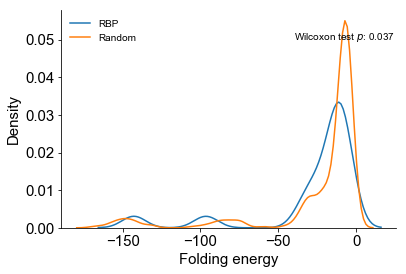

In [44]:
ax = plt.subplot()
sns.distplot(fold.energy, label = 'RBP', ax = ax, hist=False)
sns.distplot(es, label = 'Random', ax = ax, hist=False)
ax.text(-40,0.05, 'Wilcoxon test $p$: %.3f' %p)
ax.legend(frameon=False)
sns.despine()
ax.set_xlabel('Folding energy')
ax.set_ylabel('Density')
plt.savefig(figure_path + '/fold_energy.pdf', bbox_inches='tight')

In [15]:
colnames = rbp.columns.tolist()
colnames.extend(['tRNA_chrom','tRNA_start','tRNA_end','tRNA_name', 
                'tRNA_score','tRNA_strand', 'tRNA_type',
               'tRNA_id','distance'])

closest = BedTool().from_dataframe(rbp.sort_values(['chrom','start','end']))\
    .closest(b = '/stor/work/Lambowitz/ref/hg19/new_genes/tRNA.sorted.bed', d= True) \
    .to_dataframe(names = colnames) 

In [16]:
'|'.join(closest.nlargest(20, 'log10p').query('distance < 100').sense_gname)

'AC092156.2|RP11-3N2.6|JAK2|RP11-91A15.2|RP11-165H4.1'

In [17]:
RNA.fold(rbp.seq.values[2])

['.((((.((..((((...))))...(((......))).......(..((......))..))).))))...',
 -9.800000190734863]

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


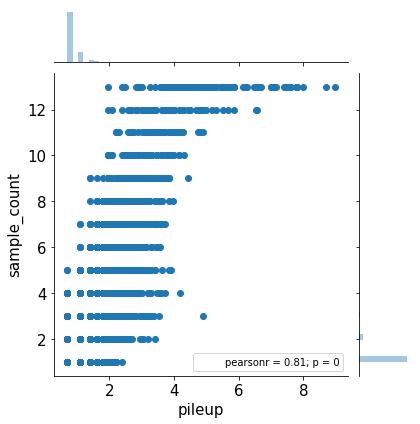

In [18]:
sns.jointplot(peak_df.pileup.transform(np.log),
            peak_df.sample_count)

In [9]:
','.join(rbp_df.head(15).index)

'UCHL5,LARP4,DHX30,EFTUD2,YBX3,XPO5,DDX6,METAP2,SND1,SRSF7,MTPAP,PCBP2,SUB1,EIF3D,TIA1'

In [10]:
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .to_csv(peak_path + '/peaks.tsv',sep='\t', index=False)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


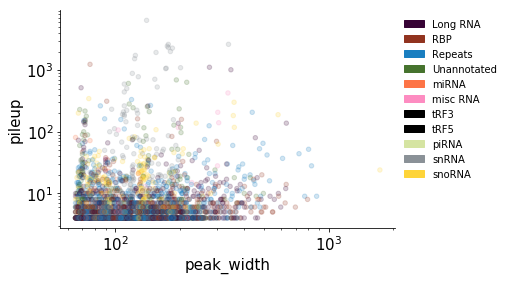

In [11]:
ax = plt.subplot()
pdf = peak_df\
    .pipe(lambda d: d[~d.sense_gtype.str.contains('tRF')])\
    .query('pileup >= %i' %pileup_cutoff)\
    .assign(peak_width = lambda d: d.end-d.start)\
    .assign(log_pile = lambda d: d.pileup.transform(np.log10))

pdf.plot.scatter('peak_width','pileup', 
                  color = ce.transform(pdf.sense_gtype), ax = ax,
                 alpha = 0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ce.show_legend(ax = ax, bbox_to_anchor =(1,1), frameon=False)
sns.despine()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


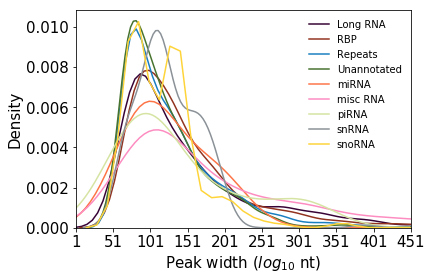

In [19]:
ax = plt.subplot()

for gt, gd in peak_df\
            .query('pileup >= %i' %(pileup_cutoff))\
            .assign(peak_width = lambda d: (d.end-d.start))\
            .groupby('sense_gtype'):
    alpha = 1 if gt in ["Long RNA"] else 1
    sns.distplot(gd.peak_width, ax = ax, kde_kws={'alpha':alpha},
                label = gt, color = ce.encoder[gt],
                hist=False)
lgd = ax.legend(frameon=False)
for lh in lgd.legendHandles: 
    lh.set_alpha(1)
ax.set_ylabel('Density')
ax.set_xlabel('Peak width ($log_{10}$ nt)')

x_range = np.arange(1,500, 50)
ax.set_xlim(x_range.min(), x_range.max())
ax.set_xticks(x_range)
for xt, x in zip(ax.get_xticklabels(), x_range):
    xt.set_text(r'$10^{%s}$' %(x))

In [ ]:
lR_peak = peak_df[peak_df.sense_gtype.str.contains('Long RNA')] \
    .sort_values('log10p', ascending=False) 
lR_peak.head(20)

In [ ]:
anti_peaks.antisense_gtype.unique()

In [ ]:
anti_peaks = peak_df.query('is_sense == "Antisense"')\
    .pipe(lambda d: d[~d.antisense_gtype.str.contains('tRF')])

NameError: name 'anti_peaks' is not defined

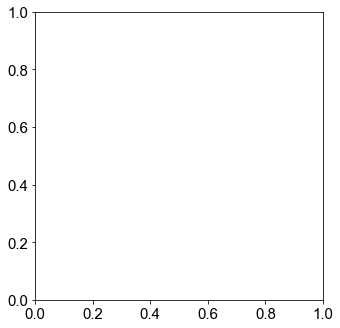

In [55]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0.1,0.4,0.8])
plot_peak_pie(anti_peaks, ax, ce, gtype='antisense_gtype')
ax = fig.add_axes([0.7, 0, 0.4, 1])
anti_plot = anti_peaks.nlargest(15, 'log10p')
anti_plot.plot\
    .bar('antisense_gname', 'log10p', 
         color = ce.transform(anti_plot\
                               .antisense_gtype),
        ax = ax)
ax.legend().set_visible(False)
ax.set_xlabel('RNA type')
ax.set_ylabel('-$log_{10}$ p-value')
sns.despine()
fig.tight_layout()
figurename = figure_path + '/peak_anti.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [ ]:
bam_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bam'
ref_path = '/stor/work/Lambowitz/ref/hg19'
tracks = {'DNase I': bam_path + '/unfragmented.bam',
         'NaOH': bam_path + '/alkaline_hydrolysis.bam',
         'sncRNA': ref_path + '/new_genes/sncRNA_viz.bed',
         'Protein': ref_path + '/new_genes/genes.bed12.bed'}
genome = ref_path + '/genome/hg19_genome.fa'

def color_func(interval):
    return 'salmon' if get_strand(interval.read) == '+' else 'steelblue'

regions = 'chr14:50329268-50329569'
matches = re.search('(chr[0-9XY]+):([0-9]+)-([0-9]+)', regions)
chrom, start, end = matches.groups()

viz = genomeview.visualize_data(tracks, chrom, int(start)-400, int(end)+400, genome)
for track in ['DNase I', 'NaOH']:
    tr = genomeview.get_one_track(viz, track)
    tr.color_fn = color_func
    if track == "DNase I":
        tr.row_height = 0.02

viz

In [ ]:
fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
fa.fetch('chr12',22158771,22158870)

In [ ]:
columns = peak_df.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand'])
intron_df = BedTool()\
    .from_dataframe(peak_df )\
    .intersect('/stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed', 
               f= 0.8,F=0.8,wb=True)\
    .to_dataframe(names = columns)
intron_df.shape

In [ ]:
intron_df \
    .query('pileup >= 5' )

In [ ]:
ss_dinucleotide = defaultdict(int)
ss_dinucleotide_seq = defaultdict(list)
seqs = []
fa = pysam.Fastafile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
def fetch_seq(chrom, start, end, strand):
    intron_seq = fa.fetch(chrom, start - 1, end)
    intron_seq = intron_seq if strand == "+" else reverse_complement(intron_seq)
    return intron_seq
    
    

intron_df = intron_df.query('pileup >=3') \
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(dinucleotide = lambda d: d.seq.str.slice(0,2) + ':' + (d.seq + 'N').str.slice(-3,-1))
intron_df.head()

In [ ]:
tablename = figure_path + '/intron_table.csv'
intron_df \
    .filter(regex='chrom|start|end|log10|pileup|intron_gene|seq') \
    .sort_values('pileup', ascending=False)\
    .to_csv(tablename, index=False)
print('Written: ', tablename)

In [ ]:
intron_df.query('pileup >= %i' %pileup_cutoff) \
    .assign(length = lambda d: d.end - d.start) \
    .describe()

In [ ]:
%load_ext autoreload
%autoreload 2
import mygene as mg
import gseapy as gsp
mgi = mg.MyGeneInfo()

glist = intron_df.query('pileup >= %i' %pileup_cutoff) \
    .filter(['pileup','gid']) \
    .assign(ensg = lambda d: d.gid.str.extract('(ENSG[0-9]+)')) \
    .assign(symbol = lambda d: list(map(lambda x: x['symbol'], mgi.getgenes(d.ensg))))

In [ ]:
glist

In [ ]:
%tb
rnk = glist\
    .filter(['symbol','pileup']) \
    .pipe(lambda d: d[~d.symbol.str.contains('^AC')])\
    .rename(columns={'symbol':'gene_name'})
#res = gsp.prerank(rnk = rnk, gene_sets='/stor/work/Lambowitz/ref/gene_sets/c2.all.v6.2.symbols.gmt')
print('\n'.join(rnk.gene_name.tolist()))



In [ ]:
peaks\
    .query('merged_type == "miRNA"')\
    .filter(regex='log10p|picked_RNA_sense')\
    .set_index('picked_RNA_sense')\
    .nlargest(10, 'log10p')\
    .plot.bar() 

In [ ]:
peaks.pipe(lambda d: d[d.picked_RNA_sense.str.contains("CGGA")])

In [ ]:
peaks\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .query('merged_type == "Repeats" | (anti_merged_type == "Repeats" & is_sense != "Sense")')

In [ ]:
peaks\
    .query('merged_type=="RBP"')\
    .pipe(lambda d: d[~d.gtype.str.contains(lrna_regex)])

In [ ]:
import gseapy as gsp

In [ ]:
res = gsp.prerank(rnk = rbp_df.sort_values(0,ascending=False),
           gene_sets = 'KEGG_2016')

In [ ]:
res.res2d

In [ ]:
aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
aln = aligner.map(fa.fetch('chr17',33981908,33982067))

In [ ]:
print(next(aln))

In [ ]:
def check_MT(peaks, return_column=False):
    mt = 0
    aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
    fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
    mts = []
    for peak_count, row in peaks.reset_index().iterrows():
        seq = fa.fetch(row['chrom'], row['start'], row['end'])
        seq = seq if row['strand'] == "+" else reverse_complement(seq)
    
        alns = aligner.map(seq)
        try:
            aln = next(alns)
            mt += 1
            mts.append('MT')
            #print(aln.cigar_str)
        except StopIteration:
            #print(row)
            mts.append('no')
            pass


    print('%i seq: %i in MT' %(peak_count, mt))
    if return_column:
        return mts

In [ ]:
anti = peak_df.query('pileup >= 5').query('is_sense == "Unannotated"')
anti['MT'] = check_MT(anti, return_column=True)

In [ ]:
peak_df.query("sense_gtype == 'tRF3'")